In [1]:
import numpy as np
import json
import tensorflow as tf
import torch
from tqdm import tqdm
import pickle

# Attention analysis

## Extracting attention from different models

### Loading the models

In [2]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer

In [3]:
model_name = "DeepPavlov/bert-base-cased-conversational"
bert_conversational_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_conversational_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at DeepPavlov/bert-base-cased-conversational were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
model_name = "microsoft/DialoGPT-medium"  
dialogpt_model = AutoModel.from_pretrained(model_name, output_attentions = True)  
dialogpt_tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/DialoGPT-medium were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
model_name = "Elron/bleurt-base-128"
bleurt_model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
bleurt_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
model_name = "./bert/gpt2-pretrained-on-dailydialog"
gpt2_model = GPT2LMHeadModel.from_pretrained(model_name)
#gpt2_tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt2_tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")

### Preparing inputs for the models

In [7]:
lst_dict = []
with open('./data/EMNLP_dataset/dialogues_text.txt', 'r') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        bleurt_tokenized = bleurt_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        bert_conversational_tokenized = bert_conversational_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        if len(bleurt_tokenized) < 513 and len(bert_conversational_tokenized) < 513:
            lst_dict.append({'bert': "[CLS] " + l.replace("__eou__", "[SEP]").replace("'", " ' ").replace("\n", ""), 
                             'gpt2': l.replace("__eou__", dialogpt_tokenizer.eos_token).replace("\n", "")})

100%|██████████| 13118/13118 [00:09<00:00, 1348.92it/s]


In [8]:
lst_dict[0]

{'bert': "[CLS] The kitchen stinks . [SEP] I ' ll throw out the garbage . [SEP]",
 'gpt2': "The kitchen stinks . <|endoftext|> I'll throw out the garbage . <|endoftext|>"}

### Extracting attentions

In [46]:
def from_torch_tensor2_numpy(tensor):
    arr = np.empty((len(tensor), tensor[0].size()[1], tensor[0].size()[-1], tensor[0].size()[-1]))
    for i, item in enumerate(tensor):
        arr[i] = item[0].cpu().detach().numpy()
        
    return arr

In [47]:
attention_dicts = {}
keys = [('bert_conversational', bert_conversational_tokenizer, 'bert', bert_conversational_model), 
        ('dialogpt', dialogpt_tokenizer, 'gpt2', dialogpt_model), 
        ('bleurt', bleurt_tokenizer, 'bert', bleurt_model)]
        #('gpt2', gpt2_tokenizer, 'gpt2', gpt2_model)]

attention_dicts = {
    k[0]: [] for k in keys
}

for k, tokenizer, model_type, model in tqdm(keys):
    for item in lst_dict[:20]:
        inputs = tokenizer.encode(item[model_type], 
                                return_tensors = 'pt', 
                                add_special_tokens = False)
        outputs = model(inputs)
        attention_dicts[k].append({'attns' : from_torch_tensor2_numpy(outputs[-1]),
                                'tokens' : tokenizer.convert_ids_to_tokens(inputs[0])})



100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


## Attention analysis

In [48]:
def data_iterator(data):
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield doc["tokens"], np.array(doc["attns"])

In [49]:
for k in attention_dicts:
    output = open(f'./data/data_attention{k}.pkl', 'wb')
    pickle.dump(attention_dicts[k], output)
    output.close()

In [51]:
np.shape(attention_dicts['bert_conversational'][0]['attns'])

(12, 12, 16, 16)

In [53]:
!! python ./clark/head_distances.py --attn-data-file ./data/data_attentionbert_conversational.pkl --outfile ./data/head_distances_attentionbert_conversational.pkl --n-layers 12 --n-heads 12 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


['Loading attention data',
 'WARNING:tensorflow:From /Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/venv/lib/python3.9/site-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.',
 'Instructions for updating:',
 'non-resource variables are not supported in the long term',
 'Computing head distances',
 '1/20 = 5.0%, ELAPSED: 0.0s, ETA: 0.0s',
 '2/20 = 10.0%, ELAPSED: 0.1s, ETA: 1.1s',
 '3/20 = 15.0%, ELAPSED: 2.6s, ETA: 14.9s',
 '4/20 = 20.0%, ELAPSED: 14.2s, ETA: 56.9s',
 '5/20 = 25.0%, ELAPSED: 15.4s, ETA: 46.2s',
 '6/20 = 30.0%, ELAPSED: 16.4s, ETA: 38.3s',
 '7/20 = 35.0%, ELAPSED: 36.2s, ETA: 67.3s',
 '8/20 = 40.0%, ELAPSED: 39.2s, ETA: 58.8s',
 '9/20 = 45.0%, ELAPSED: 55.0s, ETA: 67.2s',
 '10/20 = 50.0%, ELAPSED: 55.1s, ETA: 55.1s',
 '11/20 = 55.0%, ELAPSED: 56.6s, ETA: 46.3s',
 '12/20 = 60.0%, ELAPSED: 57.2s, ETA: 38.1s',
 '13/20 = 65.0%, ELAPSED

In [54]:
np.shape(attention_dicts['dialogpt'][0]['attns'])

(24, 16, 16, 16)

In [60]:
!! python ./clark/head_distances.py --attn-data-file ./data/data_attentiondialogpt.pkl --outfile ./data/head_distances_attentiondialogpt.pkl --n-layers 24 --n-heads 16 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
^C


[]

In [61]:
np.shape(attention_dicts['bleurt'][0]['attns'])

(12, 12, 16, 16)

In [62]:
!! python ./clark/head_distances.py --attn-data-file ./data/data_attentionbleurt.pkl --outfile ./data/head_distances_attentionbleurt.pkl --n-layers 12 --n-heads 12 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


['Loading attention data',
 'WARNING:tensorflow:From /Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/venv/lib/python3.9/site-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.',
 'Instructions for updating:',
 'non-resource variables are not supported in the long term',
 'Computing head distances',
 '1/20 = 5.0%, ELAPSED: 0.0s, ETA: 0.0s',
 '2/20 = 10.0%, ELAPSED: 0.1s, ETA: 1.0s',
 '3/20 = 15.0%, ELAPSED: 2.5s, ETA: 13.9s',
 '4/20 = 20.0%, ELAPSED: 14.3s, ETA: 57.0s',
 '5/20 = 25.0%, ELAPSED: 15.5s, ETA: 46.4s',
 '6/20 = 30.0%, ELAPSED: 16.5s, ETA: 38.6s',
 '7/20 = 35.0%, ELAPSED: 36.3s, ETA: 67.4s',
 '8/20 = 40.0%, ELAPSED: 39.1s, ETA: 58.6s',
 '9/20 = 45.0%, ELAPSED: 54.1s, ETA: 66.1s',
 '10/20 = 50.0%, ELAPSED: 54.2s, ETA: 54.2s',
 '11/20 = 55.0%, ELAPSED: 55.6s, ETA: 45.5s',
 '12/20 = 60.0%, ELAPSED: 56.1s, ETA: 37.4s',
 '13/20 = 65.0%, ELAPSED

In [63]:
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

### Computing Average Attention to Particular Tokens/Positions (Sections 3.1 and 3.2 of the Paper)

In [74]:
avg_attns = {
    k: np.zeros((12, 12)) for k in [
      "self", "right", "left", "sep", "sep_sep", "rest_sep",
      "cls", "punct"]
}

avg_attention_dicts = {
    k[0]: avg_attns.copy() for k in keys if k[0] != "dialogpt"
}

for k in avg_attention_dicts:
    js_divergences = load_pickle(f"./data/head_distances_attention{k}.pkl")
    data = attention_dicts[k]
    n_docs = len(attention_dicts[k])
    
    print("Computing token stats")
    for tokens, attns in data_iterator(data):
      n_tokens = tf.shape(attns)[-1]

      # create masks indicating where particular tokens are
      seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
      for position, token in enumerate(tokens):
        if token == "[SEP]":
          seps[position] = 1
        if token == "[CLS]":
          clss[position] = 1
        if token == "." or token == ",":
          puncts[position] = 1

      # create masks indicating which positions are relevant for each key
      # maschera: matrice [n_tokens, n_tokens]
      sep_seps = np.ones((n_tokens, n_tokens))
      #newaxis: adds dimension
      #indica le posizioni della matrice che indicano l'attenzione verso i token [SEP]
      #con l'outer product, che viene segnato con x = x * x[np.newaxis]
      sep_seps *= seps[np.newaxis]
      #indica le posizioni della matrice che indicano l'attenzione verso i token [SEP] dai token [SEP]
      sep_seps *= seps[:, np.newaxis]

      rest_seps = np.ones((n_tokens, n_tokens))
      #same as outer (x, x)
      rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
      rest_seps *= seps[np.newaxis]

      selectors = {
        # Return a 2-D array with ones on the diagonal and zeros elsewhere.
          "self": np.eye(n_tokens, n_tokens),
          "right": np.eye(n_tokens, n_tokens, 1),
          "left": np.eye(n_tokens, n_tokens, -1),
          "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
          "sep_sep": sep_seps,
          "rest_sep": rest_seps,
          "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
          "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
      }

      # get the average attention for each token type
      for key, selector in selectors.items():
        if key == "sep_sep":
          denom = 2
        elif key == "rest_sep":
          denom = n_tokens - 2
        else:
          denom = n_tokens
        avg_attention_dicts[k][key] += (
          # somma sull'ultima dimensione
            (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
            (n_docs * denom))

Computing token stats
5.0% done
100.0% done
Computing token stats
5.0% done
100.0% done


In [95]:
data = attention_dicts['bert_conversational'][0]
tokens, attns = data['tokens'], data['attns']
n_tokens = len(tokens)

In [101]:
seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
for position, token in enumerate(tokens):
    if token == "[SEP]":
        seps[position] = 1
    if token == "[CLS]":
        clss[position] = 1
    if token == "." or token == ",":
        puncts[position] = 1

In [120]:
# create masks indicating which positions are relevant for each key
sep_seps = np.ones((n_tokens, n_tokens))
print(np.shape(sep_seps))

(16, 16)


In [121]:
sep_seps *= seps[np.newaxis]
print(np.shape(sep_seps))
print(np.shape(seps))
print(np.shape(seps[np.newaxis]))

(16, 16)
(16,)
(1, 16)


In [122]:
sep_seps

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,

In [118]:
sep_seps *= seps[:, np.newaxis]
print(np.shape(sep_seps))
print(np.shape(seps))
print(np.shape(seps[:, np.newaxis]))

(16, 16)
(16,)
(16, 1)


In [119]:
sep_seps

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

### Computing Attention Head Entropies (Section 3.3)

In [79]:
uniform_attn_entropy = 0  # entropy of uniform attention
entropies = np.zeros((12, 12))  # entropy of attention heads
entropies_cls = np.zeros((12, 12))  # entropy of attention from [CLS]

entropies_attention_dicts = {
    k[0]: {'uniform_attn_entropy' : 0,
           'entropies': entropies.copy(),
           'entropies_cls': entropies_cls.copy()} for k in keys if k[0] != "dialogpt"
}
for k in entropies_attention_dicts:
  data = attention_dicts[k]
  n_docs = len(attention_dicts[k])

  print("Computing entropy stats")
  for tokens, attns in data_iterator(data):
    attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
    entropies_attention_dicts[k]['uniform_attn_entropy'] -= np.log(1.0 / attns.shape[-1])
    entropies_attention_dicts[k]['entropies'] -= (attns * np.log(attns)).sum(-1).mean(-1)
    entropies_attention_dicts[k]['entropies_cls'] -= (attns * np.log(attns))[:, :, 0].sum(-1)

  entropies_attention_dicts[k]['uniform_attn_entropy'] /= n_docs
  entropies_attention_dicts[k]['entropies'] /= n_docs
  entropies_attention_dicts[k]['entropies_cls'] /= n_docs

Computing entropy stats
5.0% done
100.0% done
Computing entropy stats
5.0% done
100.0% done


## Visualising attention

In [80]:
from bertviz import model_view, head_view, neuron_view

In [82]:
import collections
import matplotlib
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import manifold

sns.set_style("darkgrid")

### Plotting utilities

In [83]:
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(np.mean(head_data[layer]))
  return xs, ys, avgs

### Examples of Attention Head Behavior (Figure 1)

In [84]:
data = attention_dicts['bert_conversational']

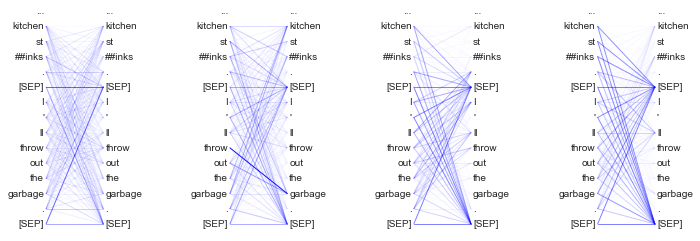

In [85]:
width = 3
example_sep = 3
word_height = 1
pad = 0.1


def plot_attn(example, heads):
  """Plots attention maps for the given example and attention heads."""

  for ei, (layer, head) in enumerate(heads):
    yoffset = 1
    xoffset = ei * width * example_sep

    attn = example["attns"][layer][head][-15:, -15:]
    attn = np.array(attn)
    attn /= attn.sum(axis=-1, keepdims=True)
    words = example["tokens"][-15:]
    words[0] = "..."
    n_words = len(words)

    for position, word in enumerate(words):
      plt.text(xoffset + 0, yoffset - position * word_height, word,
               ha="right", va="center")
      plt.text(xoffset + width, yoffset - position * word_height, word,
               ha="left", va="center")
    for i in range(1, n_words):
      for j in range(1, n_words):
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color="blue", linewidth=1, alpha=attn[i, j])

plt.figure(figsize=(12, 4))
plt.axis("off")
plot_attn(data[0], [(0, 0), (2, 0), (7, 6), (10, 5)])
plt.show()

### Avg. Attention Plots (Figure 2, Sections 3.1 and 3.2)

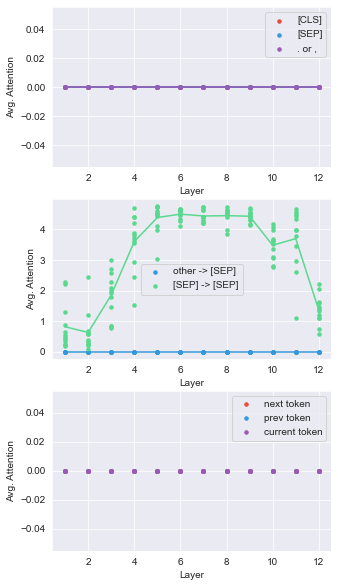

In [86]:
def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")


plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("sep", BLUE, "[SEP]"),
    ("punct", PURPLE, ". or ,"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 2)
for key, color, label in [
    ("rest_sep", BLUE, "other -> [SEP]"),
    ("sep_sep", GREEN, "[SEP] -> [SEP]"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 3)
for key, color, label in [
    ("left", RED, "next token"),
    ("right", BLUE, "prev token"),
    ("self", PURPLE, "current token"),
]:
  add_line(key, ax, color, label, plot_avgs=False)

plt.show()

### Entropy Plots (Section 3.3, Figure 4)

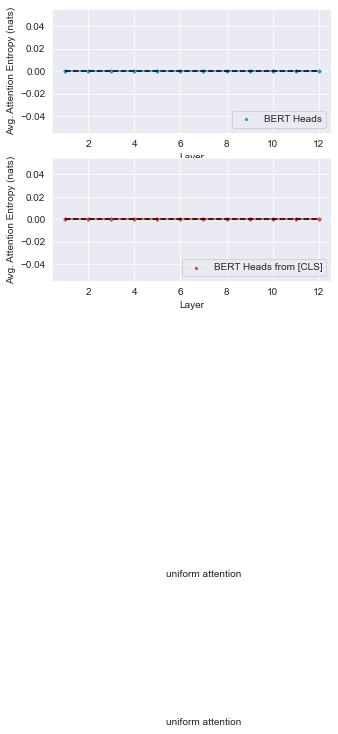

In [87]:
xs, es, avg_es = get_data_points(entropies)
xs, es_cls, avg_es_cls = get_data_points(entropies_cls)

plt.figure(figsize=(5, 5))


def plot_entropies(ax, data, avgs, label, c):
  ax.scatter(xs, data, c=c, s=5, label=label)
  ax.plot(1 + np.arange(12), avgs, c=c)
  ax.plot([1, 12], [uniform_attn_entropy, uniform_attn_entropy],
          c="k", linestyle="--")
  ax.text(7, uniform_attn_entropy - 0.45, "uniform attention",
          ha="center")
  ax.legend(loc="lower right")
  ax.set_ylabel("Avg. Attention Entropy (nats)")
  ax.set_xlabel("Layer")

plot_entropies(plt.subplot(2, 1, 1), es, avg_es, "BERT Heads",
               c=BLUE)
plot_entropies(plt.subplot(2, 1, 2), es_cls, avg_es_cls,
               "BERT Heads from [CLS]", c=RED)

plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

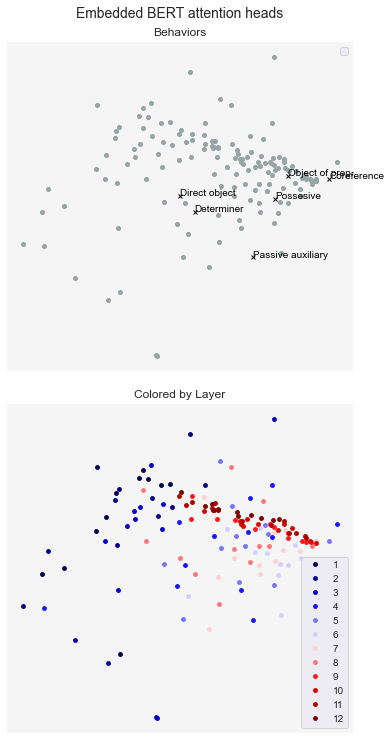

In [88]:
ENTROPY_THRESHOLD = 3.8  # When to say a head "attends broadly"
POSITION_THRESHOLD = 0.5  # When to say a head "attends to next/prev"
SPECIAL_TOKEN_THRESHOLD = 0.6  # When to say a heads attends to [CLS]/[SEP]"
# Heads that were found to have linguistic behaviors
LINGUISTIC_HEADS = {
    (4, 3): "Coreference",
    (7, 10): "Determiner",
    (7, 9): "Direct object",
    (8, 5): "Object of prep.",
    (3, 9): "Passive auxiliary",
    (6, 5): "Possesive",
}

# Use multi-dimensional scaling to compute 2-dimensional embeddings that
# reflect Jenson-Shannon divergences between attention heads.
mds = sklearn.manifold.MDS(metric=True, n_init=5, n_jobs=4, eps=1e-10,
                           max_iter=1000, dissimilarity="precomputed")
pts = mds.fit_transform(js_divergences)
pts = pts.reshape((12, 12, 2))
pts_flat = pts.reshape([144, 2])

colormap = cm.seismic(np.linspace(0, 1.0, 12))
plt.figure(figsize=(4.8, 9.6))
plt.title("BERT Attention Heads")

for color_by_layer in [False, True]:
  ax = plt.subplot(2, 1, int(color_by_layer) + 1)
  seen_labels = set()
  for layer in range(12):
    for head in range(12):
      label = ""
      color = GREY
      marker = "o"
      markersize = 4
      x, y = pts[layer, head]

      if avg_attns["right"][layer, head] > POSITION_THRESHOLD:
        color = RED
        marker = ">"
        label = "attend to next"
        
      if avg_attns["left"][layer, head] > POSITION_THRESHOLD:
        color = BLUE
        label = "attend to prev."
        marker = "<"

      if entropies[layer, head] > ENTROPY_THRESHOLD:
        color = ORANGE
        label = "attend broadly"
        marker = "^"

      if avg_attns["cls"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = PURPLE
        label = "attend to [CLS]"
        marker = "$C$"
        markersize = 5

      if avg_attns["sep"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = GREEN
        marker = "$S$"
        markersize = 5
        label = "attend to [SEP]"

      if avg_attns["punct"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = SEA
        marker = "s"
        markersize = 3.2
        label = "attend to . and ,"

      if color_by_layer:
        label = str(layer + 1)
        color = colormap[layer]
        marker = "o"
        markersize = 3.8

      if not color_by_layer:
        if (layer, head) in LINGUISTIC_HEADS:
          label = ""
          color = BLACK
          marker = "x"
          ax.text(x, y, LINGUISTIC_HEADS[(layer, head)], color=color)

      if label not in seen_labels:
        seen_labels.add(label)
      else:
        label = ""

      ax.plot([x], [y], marker=marker, markersize=markersize,
              color=color, label=label, linestyle="")

  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["bottom"].set_visible(False)
  ax.spines["left"].set_visible(False)
  ax.set_facecolor((0.96, 0.96, 0.96))
  plt.title(("Colored by Layer" if color_by_layer else "Behaviors"))
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels, loc="best")

plt.suptitle("Embedded BERT attention heads", fontsize=14, y=1.05)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0.1, wspace=0)
plt.show()